## Solving of Linear Equations on Traditional Supercomputers
### Overview
For the traditional supercomputers performance, evaluation of Linear Equation Solving  is represented by a Sparce Symmetric Matrix – we considered Cholesky decomposition [...] and a matrix storing scheme to be optimized for sparse matrix.

Cholesky decomposition, along with subsequent Gaussian elimination, can be parallelized with low overhead especially on large matrix.
This let us to keep all intermediate matrixes to be sparse, so they can kept in GPU memory.

The algorithm based on Choevsky decomposition consists of the following steps:

1. Given permutation of rows and columns of given Linear Equation matrix $P$ and vector $b$ to optimize the process for $Px = b$
2. Build the data structures necessary to compute and store $P$.
3. Perform Cholesky decomposition: $P = L*L^\top$, where $L$ is a sparse triangle matrix
4. Triangular solve: $L*y = b$ for y and then $L^\top*x=y$ for $x$.

To provide comparison to Quantum Algorithm performance evaluation, we excluded GPU data loading-unloading time.

We also conclude that each step of the algorithm is fully parallelizable, excluding sync overhead due to it being very low.

We calculate number of FLOPs for each step using:
* $N$ - matrix $P$ and vector $b$ size,
* $s$ - maximum number of non-zero elements per row (or column, that is the same as the matrix is symmetric).

### Step 1, Provide the permutation

Using matrix symmetry, we pass each line and swap the matrix elements:

$N * s * (s + 1)$

### Step 2, Build the data structures.

We can conclude the matrix is already stored in the most optimized way, so we just to generate the indexes, that takes:

$N * s$


### Step 3, Perform Cholesky decomposition.

Go through each line:

$N * (1 + s + s * s * 2)$

### Step 4, Triangular solve

Perform 2 triangular eliminations: $L*y = b$ for y and $L^\top*x=y$ for $x$:

$N * (1 + s) * 2 * 2$

### Totally FLOPs

Summarizing all the steps: $Step1 + Step2 + Step3 +Step4$
getting the result of:

$N * s * (s+1) + N * s + N * (1 + s + s * s * 2) + N * (1 + s) * 2 * 2 = N * (3s^2 + 7s + 5)$




In [6]:
# Srarase SLE FLOPs (no data transfer counted)
# N - matrix size
# s - number of non-zero elements in a row
def SparseSLECholeskyFLOP(N,s):
  return N * (3 * s**2 + 7 * s + 5)

# def SparseSLETimeHours(N,s,flops):
#   return SparseSLECholeskyFLOP(N,s) /flops / 60 / 60

def SparseSLETimeHours(N,s,flops):
  return SparseSLECholeskyFLOP(N,s) /flops / 60 / 60

In [7]:
# name, FLOP/s, energy MWh ,color
computers = [['Aurora', 1012.00e15, 38.69836, 'c'],
             ['El Capitan FP64', 61.3e12 * 11136 * 4,29.58098, 'b' ],
             ['El Capitan FP32', 122.6e12 * 11136 * 4,29.58098, 'r'],
             ['El Capitan FP16', 980.6e12 * 11136 * 4,29.58098, 'tab:orange'],
             ['El Capitan FP8', 1.96e15 * 11136 * 4,29.58098, 'tab:olive'],
             ['Frontier FP64/32',47.9E12 * 37888, 24.607, 'm' ],
            #  ['Frontier FP16',383e12* 37888, 24.607, 'tab:purple' ],
            #  ['HPC6 FP64/32', 47.9e12 * 13888, 8.6409, 'k'],
            #  ['HPC6 FP16', 383e12 * 13888, 8.6409, 'tab:gray'],
            #  ['Leonardo HPC FP64/32', 19.5e12 * 4 * 3456, 7.49374, 'tab:brown' ]]
]

In [8]:
from math import *

# returns (matrix size, max elements per row)
def getMatrixParams(n):
  return 2**n, log(2, n) 

getMatrixParams(50)

(1125899906842624, 0.17718382013555792)

PDF saved successfully!


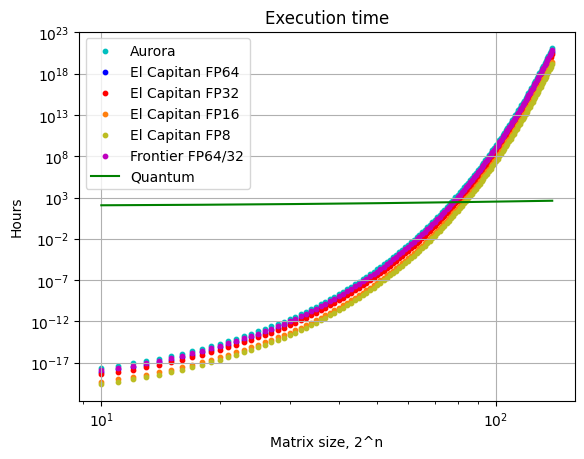

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

nrange = range(10,140,1)

for title, flops, energyMWh, color in computers:
  Hours = []
  for n in nrange:
    N, s = getMatrixParams(n)
    Hours.append(SparseSLETimeHours(N,s,flops))

  plt.scatter(nrange, Hours, s=10, color = color, label=title)
  
# for quantum computer scaling is (18 * logN + 90 * 8 + 15) * sqrt(320 / 3) * pi * kappa ^ 2 * s / epsilon^2, the clock cycle is 10 ns
quantum_hours = []
kappa = 10 
epsilon = 0.01
s = n
for n in nrange:
  N, _ = getMatrixParams(n)
  quantum_flops = (18 * log(N, 2) + 90 * 8 + 15) * sqrt(320 / 3) * pi * kappa ** 2 * s / epsilon ** 2
  # print(f"Quantum FLOPs: {quantum_flops:.2e}")
  quantum_hours.append(quantum_flops * 10e-8 / 3600)

plt.plot(nrange, quantum_hours, color='g', label='Quantum')

ax.set(xlabel= "Matrix size, 2^n", ylabel='Hours', title="Execution time")
ax.set_xscale("log")
ax.set_yscale("log")
plt.grid()
plt.legend()

# Save the figure as a PDF
# plt.savefig("execution_time.pdf")
# plt.close(fig)
try:
    plt.savefig("execution_time.pdf")
    print("PDF saved successfully!")
except Exception as e:
    print(f"Error saving PDF: {e}")

''

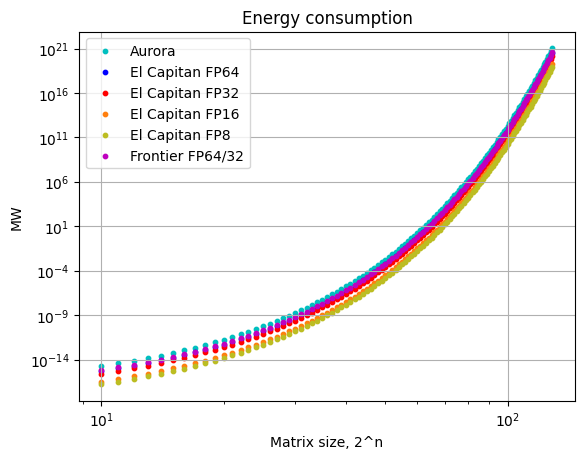

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

nrange = range(10,130,1)

for title, flops, energyMWh, color in computers:
  Energy = []
  # Hours = []
  for n in nrange:
    N, s = getMatrixParams(n)
    Energy.append(SparseSLETimeHours(N,s,flops) * energyMWh * 24)
    # Hours.append(SparseSLETimeHours(N,s,flops) / 30)

  plt.scatter(nrange, Energy, s=10, color = color, label=title)

quantum_energy = []
kappa = 10
epsilon = 0.01
s = n
for n in nrange:
  N, _ = getMatrixParams(n)
  quantum_flops = (18 * log(N, 2) + 90 * 8 + 15) * sqrt(320 / 3) * pi * kappa ** 2 * s / epsilon ** 2
  # print(f"Quantum FLOPs: {quantum_flops:.2e}")
  quantum_energy.append(quantum_flops * 10e-8 * 6.25 *  )

plt.plot(nrange, quantum_energy, color='g', label='Quantum')

ax.set(xlabel= "Matrix size, 2^n", ylabel='Hours', title="Execution time")
ax.set_xscale("log")
ax.set_yscale("log")
plt.grid()
plt.legend()


ax.set(xlabel= "Matrix size, 2^n", ylabel='MW', title="Energy consumption")
ax.set_xscale("log")
ax.set_yscale("log")
plt.grid()
plt.legend()
""

In [13]:
# Output 2**100 in scientific notation
result = 2**100
print(f"{result:.2e}")

1.27e+30
